In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sys.version

'3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:55:37) \n[Clang 14.0.6 ]'

In [3]:
%load_ext autoreload 
%autoreload 2

### Null model
$$
x_t = x_{t-1}
$$

In [4]:
train_test = pd.read_csv("../../data/train_validation_marker.csv")
train_test["SALES_DATE"] = pd.to_datetime(train_test["SALES_DATE"])
train_test.head()

,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS,max_SALES_DATE,delta_days,validation,validation_clean
0,1,2017-09-28,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,1,2022-07-31,1767,False,True
1,2,2017-11-24,CAMERA BATTERIES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,39.99,?,?,Fully-Stocked,18,2022-07-31,1710,False,True
2,3,2019-11-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,46.98,Constrained,7,2022-07-31,976,False,True
3,4,2021-04-21,SO RANGEHOODS REG,KITCHEN VENTILATION,ML - Kitchen,VP - Major Appliances,549.99,?,498,Fully-Stocked,6,2022-07-31,466,False,False
4,1,2018-10-27,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,7,2022-07-31,1373,False,True


In [5]:
#clean train/test
train = train_test[(train_test.validation==False) & (train_test.validation_clean==True)]
validation = train_test[(train_test.validation==True) & (train_test.validation_clean==True)]
train.shape,validation.shape

((797490, 15), (3815, 15))

In [6]:
validation = validation.sort_values(by = ["Encoded_SKU_ID","SALES_DATE"])

### Null model

In [7]:
sku_pred_dates = validation.groupby('Encoded_SKU_ID')['SALES_DATE'].apply(list).reset_index()
sku_pred_dates.iloc[0]["SALES_DATE"]

[Timestamp('2022-07-25 00:00:00'),
 Timestamp('2022-07-26 00:00:00'),
 Timestamp('2022-07-27 00:00:00'),
 Timestamp('2022-07-28 00:00:00'),
 Timestamp('2022-07-29 00:00:00'),
 Timestamp('2022-07-30 00:00:00'),
 Timestamp('2022-07-31 00:00:00')]

In [8]:
sku_pred_dates.shape

(545, 2)

In [9]:
last_train_day = (train["SALES_DATE"]=="2022-07-24")
last_train_day.sum()

545

In [10]:
last_pred = train[last_train_day][["Encoded_SKU_ID","DAILY_UNITS"]].reset_index(drop=True)
last_pred.head()

,Encoded_SKU_ID,DAILY_UNITS
0,10,2
1,484,2
2,520,1
3,135,0
4,344,1


In [11]:
y_pred = sku_pred_dates.merge(last_pred,on=["Encoded_SKU_ID"],how="left").rename(columns={"DAILY_UNITS":"predicted"})
y_pred.head()

,Encoded_SKU_ID,SALES_DATE,predicted
0,1,"[2022-07-25 00:00:00, 2022-07-26 00:00:00, 202...",1
1,2,"[2022-07-25 00:00:00, 2022-07-26 00:00:00, 202...",1
2,3,"[2022-07-25 00:00:00, 2022-07-26 00:00:00, 202...",2
3,5,"[2022-07-25 00:00:00, 2022-07-26 00:00:00, 202...",3
4,6,"[2022-07-25 00:00:00, 2022-07-26 00:00:00, 202...",12


In [12]:
y_pred = y_pred.explode('SALES_DATE')

### Create model

In [13]:
def rmse(y_act,y_pred):
    """
    y_act : pd df with Encoded_SKU_ID and SALES_DATE
    y_pred : pd df with Encoded_SKU_ID and SALES_DATE
    """
    assert all(y_act.dtypes.values == y_pred.dtypes.values), "Column types do not match"
    df_join = y_act.merge(y_pred,on=["Encoded_SKU_ID","SALES_DATE"])
    assert df_join.shape[0]==y_act.shape[0], "y_act and y_pred shapes do not match"
    rmse = np.sqrt(np.mean((df_join.actual-df_join.predicted)**2))
    return rmse

In [14]:
y_act = validation[["Encoded_SKU_ID","SALES_DATE","DAILY_UNITS"]].rename(columns = {"DAILY_UNITS":"actual"})
y_act.head()

,Encoded_SKU_ID,SALES_DATE,actual
82792,1,2022-07-25,0
607613,1,2022-07-26,0
225673,1,2022-07-27,0
680505,1,2022-07-28,2
394968,1,2022-07-29,2


In [15]:
y_act.dtypes.values

array([dtype('int64'), dtype('<M8[ns]'), dtype('int64')], dtype=object)

In [16]:
y_pred.dtypes

Encoded_SKU_ID             int64
SALES_DATE        datetime64[ns]
predicted                  int64
dtype: object

In [17]:
all(y_act.dtypes.values == y_pred.dtypes.values)

True

In [18]:
y_act["SALES_DATE"] = pd.to_datetime(y_act["SALES_DATE"])

In [19]:
rmse(y_act,y_pred)

6.59603916258372

### RMSR SKUs

In [53]:
def rmse_sku(y_act,y_pred, asc_sort = False):
    """
    y_act : pd df with Encoded_SKU_ID and SALES_DATE
    y_pred : pd df with Encoded_SKU_ID and SALES_DATE
    """
    assert all(y_act.dtypes.values == y_pred.dtypes.values), "Column types do not match"
    df_join = y_act.merge(y_pred,on=["Encoded_SKU_ID","SALES_DATE"])
    assert df_join.shape[0]==y_act.shape[0], "y_act and y_pred shapes do not match"
    rmse_lambda = lambda x: np.sqrt(np.mean((x.actual-x.predicted)**2))
    rmse_skus = df_join.groupby("Encoded_SKU_ID").apply(lambda x: (rmse_lambda(x),x["actual"].mean()))
    rmse_skus1 = pd.DataFrame(rmse_skus.tolist(), index=rmse_skus.index)
    rmse_skus1.columns = ["rmse_du","mean_du"]
    rmse_skus1["pct_rmse"] = rmse_skus1["rmse_du"]/rmse_skus1["mean_du"]
    return rmse_skus1.sort_values(by=["rmse_du"],ascending = asc_sort)

In [54]:
rmse_sku(y_act,y_act.rename(columns={"actual":"predicted"}))

,rmse_du,mean_du,pct_rmse
Encoded_SKU_ID,,,
1,0.0,0.857143,0.0
388,0.0,4.285714,0.0
381,0.0,17.714286,0.0
382,0.0,18.571429,0.0
384,0.0,1.857143,0.0
...,...,...,...
185,0.0,11.857143,0.0
184,0.0,3.571429,0.0
183,0.0,4.000000,0.0


In [55]:
rmse_skus = rmse_sku(y_act,y_pred)
rmse_skus

,rmse_du,mean_du,pct_rmse
Encoded_SKU_ID,,,
469,129.112354,450.857143,0.286371
50,33.316662,42.000000,0.793254
557,30.460748,70.571429,0.431630
548,25.082720,16.142857,1.553797
430,18.551088,133.714286,0.138737
...,...,...,...
15,0.377964,0.142857,2.645751
289,0.377964,0.142857,2.645751
368,0.377964,0.142857,2.645751


In [62]:
percentile = lambda x: pd.DataFrame(x.quantile(np.linspace(0.0, 1, 11)))
percentile(rmse_skus["rmse_du"])

,rmse_du
0.0,0.377964
0.1,0.755929
0.2,0.925820
0.3,1.133893
0.4,1.362770
0.5,1.558387
0.6,1.812654
0.7,2.267787
0.8,2.777460
0.9,3.809361


In [64]:
rmse_skus.head(10)

,rmse_du,mean_du,pct_rmse
Encoded_SKU_ID,,,
469,129.112354,450.857143,0.286371
50,33.316662,42.000000,0.793254
557,30.460748,70.571429,0.431630
548,25.082720,16.142857,1.553797
430,18.551088,133.714286,0.138737
74,17.341115,23.857143,0.726873
381,16.941074,17.714286,0.956351
502,12.961481,21.000000,0.617213
515,11.916375,5.285714,2.254449


### Plot prediction

In [148]:
def plot_pred_sku(train,y_act,y_pred, sku_id, start_dt = "2022-07-01"):
    """
    y_act : pd df with Encoded_SKU_ID and SALES_DATE
    y_pred : pd df with Encoded_SKU_ID and SALES_DATE
    return --> plot of actual vs predicted
    """
    assert all(y_act.dtypes.values == y_pred.dtypes.values), "Column types do not match"
    df_join = y_act.merge(y_pred,on=["Encoded_SKU_ID","SALES_DATE"])
    assert df_join.shape[0]==y_act.shape[0], "y_act and y_pred shapes do not match"
    train_sku = train[train.Encoded_SKU_ID==sku_id][["Encoded_SKU_ID","SALES_DATE","DAILY_UNITS"\
                                                ]].rename(columns={"DAILY_UNITS":'actual'})
    train_valid_sku = pd.concat([train_sku,y_act[y_act.Encoded_SKU_ID==sku_id]])
    y_pred_sku = y_pred[y_pred.Encoded_SKU_ID==sku_id]
    df_join = train_valid_sku.merge(y_pred_sku,on=["SALES_DATE"], how ="outer")
    df_join[df_join.SALES_DATE>=start_dt].plot(x="SALES_DATE",y=["actual","predicted"],color=["black","r"])
    plt.axvspan(y_pred_sku["SALES_DATE"].min(), y_pred_sku["SALES_DATE"].max(),\
            facecolor='pink', alpha=0.34, label ="Prediction week")
    plt.title (f"Actual/Predicted sales of sku:{sku_id} from {train_valid_sku.SALES_DATE.min():%Y-%m-%d} to {y_pred_sku.SALES_DATE.max():%Y-%m-%d}")
    plt.legend()

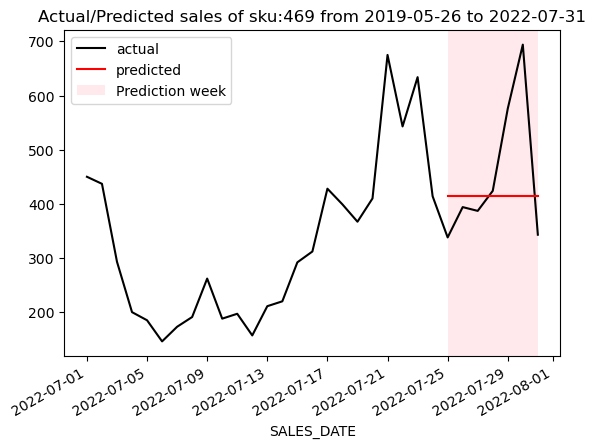

In [149]:
plot_pred_sku(train,y_act, y_pred, 469)

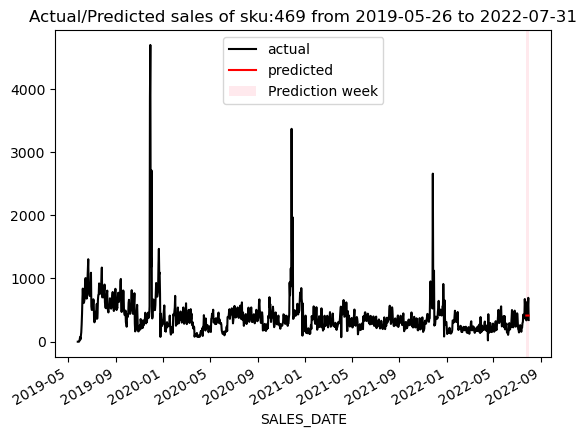

In [150]:
plot_pred_sku(train,y_act, y_pred, 469, "2014-05-01")

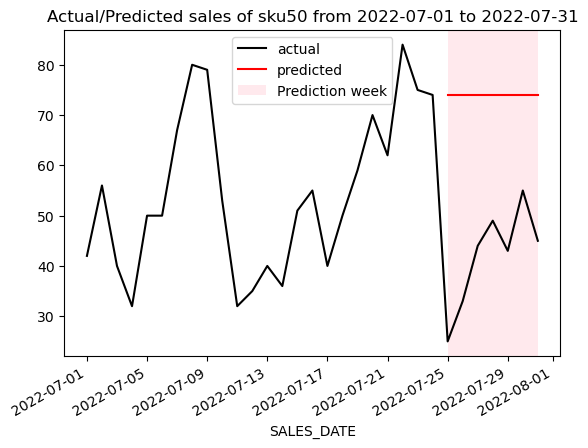

In [144]:
plot_pred_sku(train,y_act,y_pred,50)

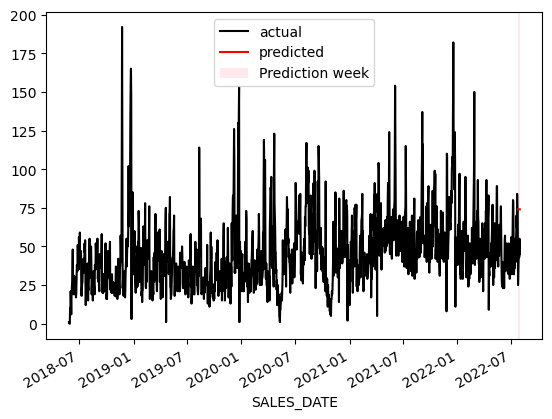

In [128]:
plot_pred_sku(train,y_act,y_pred,50, "2016-03-01")